In [1]:
import numpy as np
import commpy as cp
from commpy.channelcoding import Trellis
from commpy.modulation import QAMModem, PSKModem

import utils
from signal_generator import SignalGenerator

# For visualization
import pylab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set()

## Experiment Hyper-parameters

In [2]:
NUM_EXAMPLES = 10000  # 9k samples train, 1k for dev, 1k for dev
BLOCK_LEN = 100
SNR_MAX   = 15 # [0.5,1] 100 
SNR       = SNR_MAX 

modem = PSKModem(16)  # Constellation  QAM16
trellis = Trellis(memory   = np.array([2]), 
                  g_matrix = np.array([[0o7, 0o5]]) , 
                  feedback = 0o7, 
                  code_type= 'rsc')

## Train a Neural Network to classify constellation

### Split data into training/dev/test

* Dev and Test set should have similar distribution.
* Split into 80/10/10.
* Adopt from : https://cs230-stanford.github.io/train-dev-test-split.html

In [3]:
import random 

# Generate data for training
data_gen = SignalGenerator(modem=modem)
_, clean_signals, noisy_signals = data_gen(NUM_EXAMPLES, BLOCK_LEN, SNR)

# Split data into train/dev/test
dataset = list(zip(noisy_signals, clean_signals))

# Shuffle Before splitting the data
random.shuffle(dataset)
split1 = int(0.8 * len(dataset))
split2 = int(0.9 * len(dataset))
train_set = dataset[:split1]
dev_set = dataset[split1:split2]
test_set = dataset[split2:]

print(len(train_set), len(dev_set), len(test_set))

8000 1000 1000


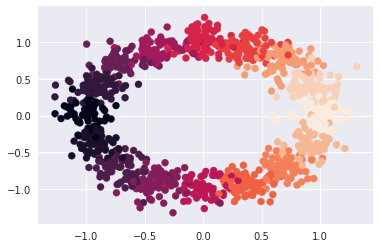

In [4]:
inputs = noisy_signals.flatten()[0:1000]
_, groundtruths = np.unique(clean_signals, return_inverse=True)
plt.scatter(np.real(inputs), np.imag(inputs), c=groundtruths[0:1000])

### Data Preparation
* Inputs: shape [N, 2]  - Encode complex input arrays into 2-D array. 
* Labels: shape [N , C] - One-hot encoded labels of complex grouth truths that have C classes (4, 8, 16,...).

In [5]:
NUM_CLASSES =  modem.m
def get_trainable_data(x, y):
    """Encode complex numbers to trainable data and one_hot labels"""
    x = np.stack((np.array(x).real, np.array(x).imag), axis=-1).reshape((-1, 2))
    _, ground_truths = np.unique(y, return_inverse=True)
    # One hot encoding
    y = np.zeros((ground_truths.size, NUM_CLASSES))
    y[np.arange(ground_truths.size), ground_truths] = 1
    return x, y

x_train, y_train = zip(*train_set)
x_dev, y_dev = zip(*dev_set)
x_test, y_test = zip(*test_set)
X_train, Y_train = get_trainable_data(x_train, y_train)
X_dev, Y_dev = get_trainable_data(x_dev, y_dev)
X_test, Y_test = get_trainable_data(x_test, y_test)

print('Training data')
print(X_train.shape, X_dev.shape, X_test.shape)

Training data
(408000, 2) (51000, 2) (51000, 2)


#### Create a simple NN for classification task

In [7]:
## Simple Classification
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense

num_classes = modem.m

tf.keras.backend.clear_session()

inputs  = Input(shape=(2,))
hiddens = Dense(64, use_bias=True, activation='relu')(inputs)
hiddens = Dense(64, use_bias=True, activation='relu')(inputs)
outputs = Dense(num_classes, use_bias=True, activation='softmax')(hiddens)
model = tf.keras.Model(inputs, outputs)
model.compile('adam','categorical_crossentropy', metrics=['acc'])

model.fit(X_train, Y_train, 
          validation_data=(X_dev, Y_dev), 
          epochs=5, batch_size=512)
_, accuracy = model.evaluate(X_test, Y_test)

print('Test Accuracy: %f' % accuracy)

Train on 408000 samples, validate on 51000 samples
Epoch 1/5
408000/408000 [==============================] - 2s 5us/step - loss: 1.1457 - acc: 0.7685 - val_loss: 0.5587 - val_acc: 0.8785
Epoch 2/5
408000/408000 [==============================] - 2s 5us/step - loss: 0.4326 - acc: 0.8775 - val_loss: 0.3548 - val_acc: 0.8799
Epoch 3/5
408000/408000 [==============================] - 2s 5us/step - loss: 0.3324 - acc: 0.8779 - val_loss: 0.3136 - val_acc: 0.8798
Epoch 4/5
408000/408000 [==============================] - 2s 5us/step - loss: 0.3116 - acc: 0.8780 - val_loss: 0.3043 - val_acc: 0.8800
Epoch 5/5
51000/51000 [==============================] - 1s 22us/step
Test Accuracy: 0.880196


### Compare and Visualize against Baseline

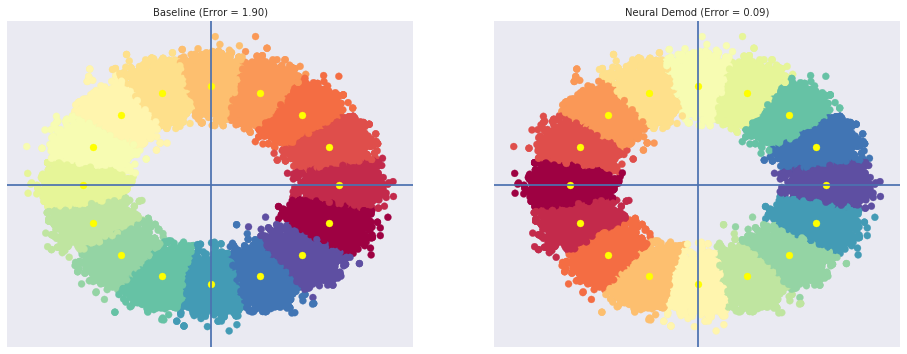

In [8]:
import utils
from baseline_receiver import BaselineReceiver

baseline = BaselineReceiver(modem, trellis)

complex_inputs = np.array(x_test).flatten()
_, ground_truths = np.unique(y_test, return_inverse=True)


baseline_predictions = baseline.demodulate(complex_inputs)
nn_predictions = np.argmax(model.predict(X_test), -1)

acc, err = utils.get_scores(ground_truths, baseline_predictions)
nn_acc, nn_err = utils.get_scores(ground_truths, nn_predictions)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

utils.visualize_demodulation(
    complex_inputs,
    modem.constellation, 
    ax1, 'Baseline (Error = %.2f)' % err,
    baseline_predictions)

utils.visualize_demodulation(
    complex_inputs,
    modem.constellation, 
    ax2, 'Neural Demod (Error = %.2f)' % nn_err,
    nn_predictions)


In [9]:
model.save('demod_modem_psk16.hdf5')